In [1]:
import os

import tifffile
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import wandb
from torchvision import transforms as T
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader, Dataset
from einops import rearrange
from kmeans_pytorch import kmeans, kmeans_predict

In [2]:
wandb.login()

wandb: Currently logged in as: estorrs (tme-st). Use `wandb login --relogin` to force relogin


True

In [3]:
%load_ext autoreload

In [4]:
%autoreload 2

In [5]:
from dino_extended.data.utils import listfiles, extract_ome_tiff, get_ome_tiff_channels, make_pseudo
from dino_extended.data.multiplex import TileTransform, TileDataset, MultichannelAug
from dino_extended.models.dino import Dino
from dino_extended.models.vit import ViT, Recorder, Extractor

In [6]:
fps = sorted(listfiles('/data/estorrs/mushroom/data/test_registration/HT397B1/registered/', regex=r'ome.tiff$'))
fps

['/data/estorrs/mushroom/data/test_registration/HT397B1/registered/s1.ome.tiff',
 '/data/estorrs/mushroom/data/test_registration/HT397B1/registered/s2.ome.tiff']

In [7]:
for fp in fps:
    print(get_ome_tiff_channels(fps[0]))

/data/estorrs/miniconda3/envs/dino_extended/lib/python3.9/site-packages/ome_types/_convenience.py:106: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)


['DAPI', 'CD8', 'Her2 (D)', 'GATA3 (D)', 'cKIT-(D)', 'Pan-Cytokeratin', 'GLUT1-(D)', 'Podoplanin', 'CD68 (D)', 'HLA-DR', 'Keratin 14', 'FoxP3', 'MGP-(D)', 'CD20-(D)', 'SMA-(D)', 'Ki67', 'Vimentin-(D)', 'PR-(D)', 'Bap1 (D)', 'CD45 (D)', 'ER', 'CD31', 'COX6c (D)', 'CK19', 'PLAT/tPA (D)']
['DAPI', 'CD8', 'Her2 (D)', 'GATA3 (D)', 'cKIT-(D)', 'Pan-Cytokeratin', 'GLUT1-(D)', 'Podoplanin', 'CD68 (D)', 'HLA-DR', 'Keratin 14', 'FoxP3', 'MGP-(D)', 'CD20-(D)', 'SMA-(D)', 'Ki67', 'Vimentin-(D)', 'PR-(D)', 'Bap1 (D)', 'CD45 (D)', 'ER', 'CD31', 'COX6c (D)', 'CK19', 'PLAT/tPA (D)']


In [8]:
channels = sorted(get_ome_tiff_channels(fps[0]))
channels

['Bap1 (D)',
 'CD20-(D)',
 'CD31',
 'CD45 (D)',
 'CD68 (D)',
 'CD8',
 'CK19',
 'COX6c (D)',
 'DAPI',
 'ER',
 'FoxP3',
 'GATA3 (D)',
 'GLUT1-(D)',
 'HLA-DR',
 'Her2 (D)',
 'Keratin 14',
 'Ki67',
 'MGP-(D)',
 'PLAT/tPA (D)',
 'PR-(D)',
 'Pan-Cytokeratin',
 'Podoplanin',
 'SMA-(D)',
 'Vimentin-(D)',
 'cKIT-(D)']

In [9]:
channels = [
#     'CD68 (D)', not working in this batch
    'CD20-(D)',
    ('CD31', 98.),
    ('CD45 (D)', 98.),
    'CD8',
    'CK19',
    ('DAPI', 98.),
    'ER',
    ('FoxP3', 99.5),
    'GATA3 (D)',
    'GLUT1-(D)',
    'HLA-DR',
    'Her2 (D)',
    ('Keratin 14', 98.),
    'Ki67',
    ('MGP-(D)', 98.),
#     'PLAT/tPA (D)',
    'PR-(D)',
    ('Pan-Cytokeratin', 95.),
    'Podoplanin',
    'SMA-(D)',
    'Vimentin-(D)',
    'cKIT-(D)'
]

channel_names = [c if not isinstance(c, tuple) else c[0] for c in channels]

In [10]:
from skimage.exposure import rescale_intensity
def preprocess_ome(fp, scale=None, default_contrast_pct=90., channels=None):
    if channels is not None:
        contrast_pcts = [default_contrast_pct if not isinstance(c, tuple) else c[1] for c in channels]
        channels = [c if not isinstance(c, tuple) else c[0] for c in channels]
    else:
        channels = sorted(get_ome_tiff_channels(fp))
        contrast_pcts = [default_contrast_pct] * len(channels)
        
    channel_to_img = extract_ome_tiff(fp, channels=channels)
    
    for c, contrast_pct in zip(channels, contrast_pcts):
        print(c)
        img = channel_to_img[c]
        try:
            vmax = np.percentile(img[img>0], (contrast_pct)) if np.count_nonzero(img) else 1.
            img[img>vmax] = vmax
            
#             img = rescale_intensity(img, in_range=(0., vmax)).astype(np.float32)
            img = img.astype(np.float32)
            img -= img.min()
            img /= img.max()
            channel_to_img[c] = torch.tensor(img, dtype=torch.float32).unsqueeze(dim=0)
#             plt.imshow(channel_to_img[c][0])
#             plt.title(c)
#             plt.show()
        except IndexError:
            print(f'channel {c} failed intensity rescaling')
            
    stacked = torch.concat([channel_to_img[c] for c in channels], dim=0)
    
    return stacked, channels

In [11]:
imgs = []
for fp in fps:
    print(fp)
    stacked, _ = preprocess_ome(fp, default_contrast_pct=90., channels=channels)
    imgs.append(stacked)
len(imgs)

/data/estorrs/mushroom/data/test_registration/HT397B1/registered/s1.ome.tiff
CD20-(D)
CD31
CD45 (D)
CD8
CK19
DAPI
ER
FoxP3
GATA3 (D)
GLUT1-(D)
HLA-DR
Her2 (D)
Keratin 14
Ki67
MGP-(D)
PR-(D)
Pan-Cytokeratin
Podoplanin
SMA-(D)
Vimentin-(D)
cKIT-(D)
/data/estorrs/mushroom/data/test_registration/HT397B1/registered/s2.ome.tiff
CD20-(D)
CD31
CD45 (D)
CD8
CK19
DAPI
ER
FoxP3
GATA3 (D)
GLUT1-(D)
HLA-DR
Her2 (D)
Keratin 14
Ki67
MGP-(D)
PR-(D)
Pan-Cytokeratin
Podoplanin
SMA-(D)
Vimentin-(D)
cKIT-(D)


2

In [12]:
size = (256, 256)
scale = .5
ds = TileDataset(imgs, size=size, scale=scale)

In [13]:
tile = ds[0]
tile.shape

torch.Size([21, 256, 256])

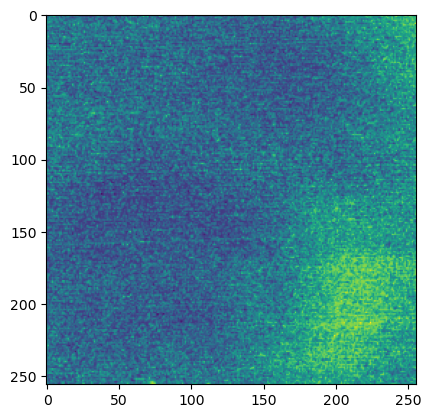

In [14]:
plt.imshow(tile[channel_names.index('DAPI')])

In [15]:
means, stds = imgs[0].mean(dim=(-2, -1)), imgs[0].std(dim=(-2, -1))
means, stds

(tensor([0.1586, 0.0414, 0.0964, 0.0873, 0.0987, 0.1984, 0.0965, 0.0211, 0.0992,
         0.2672, 0.1814, 0.0618, 0.0215, 0.0547, 0.1548, 0.1675, 0.1076, 0.1600,
         0.1335, 0.1834, 0.1849]),
 tensor([0.2642, 0.1133, 0.1728, 0.2097, 0.2543, 0.2140, 0.2381, 0.0604, 0.2465,
         0.3074, 0.2801, 0.1795, 0.0867, 0.1684, 0.1838, 0.2781, 0.2674, 0.2673,
         0.2536, 0.3077, 0.2922]))

In [23]:
batch_size = 128
dl = DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=20)

In [17]:
b = next(iter(dl))
b.shape

torch.Size([128, 21, 256, 256])

In [16]:
n_image_channels = len(channel_names)

In [19]:
from pathlib import Path
project = 'codex_dino'
run_dir = f'/data/estorrs/DINO-extended/data/runs/HT397B1/{project}'
log_dir = os.path.join(run_dir, 'logs')
chkpt_dir = os.path.join(run_dir, 'chkpts')
Path(log_dir).mkdir(parents=True, exist_ok=True)
Path(chkpt_dir).mkdir(parents=True, exist_ok=True)

In [20]:
run = wandb.init(
  project=project,
)

In [21]:
# wandb.finish()

In [24]:
config = {
    'epochs': 1000,
    'lr': 3e-4,
    'batch_size': batch_size,
    'vit': {
        'image_size': size[0],
        'channels': n_image_channels,
        'patch_size': 32,
        'num_classes': 100,
        'dim': 1024,
        'depth': 6,
        'heads': 8,
        'mlp_dim': 2048
    },
    'dino': {
        'is_multichannel': True,
        'n_image_channels': n_image_channels,
        'scale': scale,
        'means': list(means.numpy()),
        'stds': list(stds.numpy()),
        'image_size': size[0],
        'hidden_layer': 'to_latent',
        'projection_hidden_size': 256,      # projector network hidden dimension
        'projection_layers': 4,             # number of layers in projection network
        'num_classes_K': 65336,             # output logits dimensions (referenced as K in paper)
        'student_temp': 0.9,                # student temperature
        'teacher_temp': 0.04,               # teacher temperature, needs to be annealed from 0.04 to 0.07 over 30 epochs
        'local_upper_crop_scale': 0.4,      # upper bound for local crop - 0.4 was recommended in the paper 
        'global_lower_crop_scale': 0.5,     # lower bound for global crop - 0.5 was recommended in the paper
        'moving_average_decay': 0.9,        # moving average of encoder - paper showed anywhere from 0.9 to 0.999 was ok
        'center_moving_average_decay': 0.9, # moving average of teacher centers - paper showed anywhere from 0.9 to 0.999 was ok
        'teacher_temps': list(np.linspace(.04, .07, 30))
    }
}

wandb.config = config

In [23]:
model = ViT(
    image_size = size[0],
    channels = n_image_channels,
    patch_size = 32,
    num_classes = 100,
    dim = 1024,
    depth = 6,
    heads = 8,
    mlp_dim = 2048
)

In [24]:
learner = Dino(
    model,
    is_multichannel=True,
    n_image_channels=n_image_channels,
    means=means,
    stds=stds,
    image_size = size[0],
    hidden_layer = 'to_latent',        # hidden layer name or index, from which to extract the embedding
    projection_hidden_size = 256,      # projector network hidden dimension
    projection_layers = 4,             # number of layers in projection network
    num_classes_K = 65336,             # output logits dimensions (referenced as K in paper)
    student_temp = 0.9,                # student temperature
    teacher_temp = 0.04,               # teacher temperature, needs to be annealed from 0.04 to 0.07 over 30 epochs
    local_upper_crop_scale = 0.4,      # upper bound for local crop - 0.4 was recommended in the paper 
    global_lower_crop_scale = 0.5,     # lower bound for global crop - 0.5 was recommended in the paper
    moving_average_decay = 0.9,        # moving average of encoder - paper showed anywhere from 0.9 to 0.999 was ok
    center_moving_average_decay = 0.9, # moving average of teacher centers - paper showed anywhere from 0.9 to 0.999 was ok
)

/data/estorrs/miniconda3/envs/dino_extended/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [25]:
def get_cluster_images(model, embeddings):
    x = embeddings[:, 1:]
    orig_shape = x.shape
    x = rearrange(x, 'b p d -> (b p) d')
    cluster_ids_x, cluster_centers = kmeans(
        X=x, num_clusters=10, tol=1., distance='euclidean', device=torch.device('cuda:0')
    )
    reshaped = rearrange(cluster_ids_x, '(b p) -> b p', p=orig_shape[1])
    img = rearrange(reshaped, 'b (h w) -> b h w', h=int(np.sqrt(orig_shape[1])))
    
    img = img.to(torch.float32)
    img -= img.min()
    img /= img.max()
    
    return img

def log_media(model, dl, n_show=16, n_batches=5, channels=['DAPI', 'Pan-Cytokeratin', 'CD45 (D)']):
    embeddings = []
    imgs = None
    v = Extractor(model)
    with torch.no_grad():
        for i, b in enumerate(dl):
            if i == n_batches:
                break
            b = b.to(0)
            _, embs = v(b)
            embeddings.append(embs)
            
            if imgs is None:
                imgs = b[:n_show, [channel_names.index(c) for c in channels]]
    
    embeddings = torch.concat(tuple(embeddings), dim=0)
    cluster_imgs = get_cluster_images(model, embeddings)[:n_show].unsqueeze(dim=1).numpy()
    cluster_imgs = rearrange(cluster_imgs, 'b c h w -> b h w c')
    
    pseudo = [np.expand_dims(make_pseudo(img.detach().cpu().numpy()), 0) for img in imgs]
    pseudo = np.concatenate(pseudo, axis=0)
    
    wandb.log({
        'train/pseudo': [wandb.Image(x) for x in pseudo],
        'train/clustered': [wandb.Image(x) for x in cluster_imgs]
    })
    
    v = v.eject()
    

    
    return cluster_imgs, pseudo

In [26]:
len(dl)

64

In [27]:
learner = learner.to(0)

In [28]:
teacher_temps = np.linspace(.04, .07, 30)
teacher_temps

array([0.04      , 0.04103448, 0.04206897, 0.04310345, 0.04413793,
       0.04517241, 0.0462069 , 0.04724138, 0.04827586, 0.04931034,
       0.05034483, 0.05137931, 0.05241379, 0.05344828, 0.05448276,
       0.05551724, 0.05655172, 0.05758621, 0.05862069, 0.05965517,
       0.06068966, 0.06172414, 0.06275862, 0.0637931 , 0.06482759,
       0.06586207, 0.06689655, 0.06793103, 0.06896552, 0.07      ])

In [29]:
epochs = config['epochs']
lr = config['lr']
opt = torch.optim.Adam(learner.parameters(), lr=lr)

In [30]:
media_log_every = 10
chkpt_every = 50

In [31]:
for e in range(epochs):
    epoch_loss = None
    for b in dl:
        b = b.to(0)
        loss = learner(b)
        opt.zero_grad()
        loss.backward()
        opt.step()
        learner.update_moving_average() # update moving average of teacher encoder and teacher centers
        
        if epoch_loss is None:
            epoch_loss = loss.detach().cpu().item()
        else:
            epoch_loss += loss.detach().cpu().item()
    result = {"train/loss": epoch_loss / len(dl), 'n_steps': e * len(dl) * batch_size, 'epoch': e}
    print(result)
    wandb.log(result)
    if e % media_log_every == 0:
        log_media(model, dl)
    
    if e < 29:
        learner.teacher_temp = teacher_temps[e + 1]
        
    if e % chkpt_every == 0:
        torch.save(model.state_dict(), os.path.join(chkpt_dir, f'{e}.pt'))
    

{'train/loss': 10.919760182499886, 'n_steps': 0, 'epoch': 0}
running k-means on cuda:0..


[running kmeans]: 19it [00:14,  1.32it/s, center_shift=0.931810, iteration=19, tol=1.000000]   


{'train/loss': 10.370104685425758, 'n_steps': 8192, 'epoch': 1}
{'train/loss': 9.695628732442856, 'n_steps': 16384, 'epoch': 2}
{'train/loss': 8.864667668938637, 'n_steps': 24576, 'epoch': 3}
{'train/loss': 8.022582322359085, 'n_steps': 32768, 'epoch': 4}
{'train/loss': 6.9989446848630905, 'n_steps': 40960, 'epoch': 5}
{'train/loss': 5.680298022925854, 'n_steps': 49152, 'epoch': 6}
{'train/loss': 4.579083256423473, 'n_steps': 57344, 'epoch': 7}
{'train/loss': 3.266905717551708, 'n_steps': 65536, 'epoch': 8}
{'train/loss': 2.4762778598815203, 'n_steps': 73728, 'epoch': 9}
{'train/loss': 1.885068453848362, 'n_steps': 81920, 'epoch': 10}
running k-means on cuda:0..


[running kmeans]: 62it [00:42,  1.45it/s, center_shift=0.009690, iteration=62, tol=1.000000]   


{'train/loss': 1.6421518977731466, 'n_steps': 90112, 'epoch': 11}
{'train/loss': 1.3562665274366736, 'n_steps': 98304, 'epoch': 12}
{'train/loss': 1.2187458630651236, 'n_steps': 106496, 'epoch': 13}
{'train/loss': 1.0905555952340364, 'n_steps': 114688, 'epoch': 14}
{'train/loss': 0.9762562531977892, 'n_steps': 122880, 'epoch': 15}
{'train/loss': 1.291785174049437, 'n_steps': 131072, 'epoch': 16}
{'train/loss': 1.3490458577871323, 'n_steps': 139264, 'epoch': 17}
{'train/loss': 1.369208944030106, 'n_steps': 147456, 'epoch': 18}
{'train/loss': 1.1687251077964902, 'n_steps': 155648, 'epoch': 19}
{'train/loss': 0.8963901735842228, 'n_steps': 163840, 'epoch': 20}
running k-means on cuda:0..


[running kmeans]: 124it [01:25,  1.45it/s, center_shift=0.000000, iteration=124, tol=1.000000]  


{'train/loss': 0.7587518068030477, 'n_steps': 172032, 'epoch': 21}
{'train/loss': 0.5423589996062219, 'n_steps': 180224, 'epoch': 22}
{'train/loss': 0.5299690309911966, 'n_steps': 188416, 'epoch': 23}
{'train/loss': 0.43473749165423214, 'n_steps': 196608, 'epoch': 24}
{'train/loss': 0.39075264777056873, 'n_steps': 212992, 'epoch': 26}
{'train/loss': 0.3266214507166296, 'n_steps': 221184, 'epoch': 27}
{'train/loss': 0.33423459553159773, 'n_steps': 229376, 'epoch': 28}
{'train/loss': 0.3004322540946305, 'n_steps': 237568, 'epoch': 29}
{'train/loss': 0.24304473935626447, 'n_steps': 245760, 'epoch': 30}
running k-means on cuda:0..


[running kmeans]: 106it [01:12,  1.46it/s, center_shift=0.919504, iteration=106, tol=1.000000]  
/data/estorrs/DINO-extended/dino_extended/data/utils.py:67: RuntimeWarning: invalid value encountered in divide
  new /= new.max()


{'train/loss': 0.23055276763625443, 'n_steps': 253952, 'epoch': 31}
{'train/loss': 0.22413198347203434, 'n_steps': 262144, 'epoch': 32}
{'train/loss': 0.20943829242605716, 'n_steps': 270336, 'epoch': 33}
{'train/loss': 0.1907342320191674, 'n_steps': 278528, 'epoch': 34}
{'train/loss': 0.19505270931404084, 'n_steps': 286720, 'epoch': 35}
{'train/loss': 0.19790314650163054, 'n_steps': 294912, 'epoch': 36}
{'train/loss': 0.1696401505614631, 'n_steps': 303104, 'epoch': 37}
{'train/loss': 0.16423883743118495, 'n_steps': 311296, 'epoch': 38}
{'train/loss': 0.17132512712851167, 'n_steps': 319488, 'epoch': 39}
{'train/loss': 0.1666145077906549, 'n_steps': 327680, 'epoch': 40}
running k-means on cuda:0..


[running kmeans]: 65it [00:44,  1.45it/s, center_shift=0.416754, iteration=65, tol=1.000000]    


{'train/loss': 0.16268473956733942, 'n_steps': 335872, 'epoch': 41}
{'train/loss': 0.1500821819063276, 'n_steps': 344064, 'epoch': 42}
{'train/loss': 0.14271230052690953, 'n_steps': 352256, 'epoch': 43}
{'train/loss': 0.14044573088176548, 'n_steps': 360448, 'epoch': 44}
{'train/loss': 0.1327204433036968, 'n_steps': 368640, 'epoch': 45}
{'train/loss': 0.12839913502102718, 'n_steps': 376832, 'epoch': 46}
{'train/loss': 0.13384823012165725, 'n_steps': 385024, 'epoch': 47}
{'train/loss': 0.12729394948109984, 'n_steps': 393216, 'epoch': 48}
{'train/loss': 0.12375523732043803, 'n_steps': 401408, 'epoch': 49}
{'train/loss': 0.12317523616366088, 'n_steps': 409600, 'epoch': 50}
running k-means on cuda:0..


[running kmeans]: 52it [00:35,  1.45it/s, center_shift=0.754170, iteration=52, tol=1.000000]    


{'train/loss': 0.11798047239426523, 'n_steps': 417792, 'epoch': 51}
{'train/loss': 0.11748034169431776, 'n_steps': 425984, 'epoch': 52}
{'train/loss': 0.12146639887942001, 'n_steps': 434176, 'epoch': 53}
{'train/loss': 0.10219610610511154, 'n_steps': 442368, 'epoch': 54}
{'train/loss': 0.11584085470531136, 'n_steps': 450560, 'epoch': 55}
{'train/loss': 0.11997965269256383, 'n_steps': 458752, 'epoch': 56}
{'train/loss': 0.12463094992563128, 'n_steps': 466944, 'epoch': 57}
{'train/loss': 0.19214308803202584, 'n_steps': 475136, 'epoch': 58}
{'train/loss': 0.11709847731981426, 'n_steps': 483328, 'epoch': 59}
{'train/loss': 0.12274829851230606, 'n_steps': 491520, 'epoch': 60}
running k-means on cuda:0..


[running kmeans]: 59it [00:40,  1.46it/s, center_shift=0.888186, iteration=59, tol=1.000000]    


{'train/loss': 0.10931006888858974, 'n_steps': 499712, 'epoch': 61}
{'train/loss': 0.11709991848329082, 'n_steps': 507904, 'epoch': 62}
{'train/loss': 0.11852003709645942, 'n_steps': 516096, 'epoch': 63}
{'train/loss': 0.12200585135724396, 'n_steps': 524288, 'epoch': 64}
{'train/loss': 0.10673610086087137, 'n_steps': 532480, 'epoch': 65}
{'train/loss': 0.12757285201223567, 'n_steps': 540672, 'epoch': 66}
{'train/loss': 0.10198364272946492, 'n_steps': 548864, 'epoch': 67}
{'train/loss': 0.10065614059567451, 'n_steps': 557056, 'epoch': 68}
{'train/loss': 0.09502660104772076, 'n_steps': 565248, 'epoch': 69}
{'train/loss': 0.0742669755127281, 'n_steps': 573440, 'epoch': 70}
running k-means on cuda:0..


[running kmeans]: 46it [00:31,  1.45it/s, center_shift=0.310072, iteration=46, tol=1.000000]    


{'train/loss': 0.07579404459102079, 'n_steps': 581632, 'epoch': 71}
{'train/loss': 0.0729432143853046, 'n_steps': 589824, 'epoch': 72}
{'train/loss': 0.06080051057506353, 'n_steps': 598016, 'epoch': 73}
{'train/loss': 0.058647394413128495, 'n_steps': 606208, 'epoch': 74}
{'train/loss': 0.06938408373389393, 'n_steps': 614400, 'epoch': 75}
{'train/loss': 0.07076893700286746, 'n_steps': 622592, 'epoch': 76}
{'train/loss': 0.05942221074656118, 'n_steps': 630784, 'epoch': 77}
{'train/loss': 0.051052759066806175, 'n_steps': 638976, 'epoch': 78}
{'train/loss': 0.05794530551065691, 'n_steps': 647168, 'epoch': 79}
{'train/loss': 0.058614085559383966, 'n_steps': 655360, 'epoch': 80}
running k-means on cuda:0..


[running kmeans]: 45it [00:31,  1.45it/s, center_shift=0.231865, iteration=45, tol=1.000000]    


{'train/loss': 0.05243613901984645, 'n_steps': 663552, 'epoch': 81}
{'train/loss': 0.052707172493683174, 'n_steps': 671744, 'epoch': 82}
{'train/loss': 0.05685815145261586, 'n_steps': 679936, 'epoch': 83}
{'train/loss': 0.0505092093226267, 'n_steps': 688128, 'epoch': 84}
{'train/loss': 0.04600459858193062, 'n_steps': 696320, 'epoch': 85}
{'train/loss': 0.062935395661043, 'n_steps': 704512, 'epoch': 86}
{'train/loss': 0.06641626288183033, 'n_steps': 712704, 'epoch': 87}
{'train/loss': 0.05834420086466707, 'n_steps': 720896, 'epoch': 88}
{'train/loss': 0.05164392247388605, 'n_steps': 729088, 'epoch': 89}
{'train/loss': 0.051141111107426696, 'n_steps': 737280, 'epoch': 90}
running k-means on cuda:0..


[running kmeans]: 30it [00:20,  1.46it/s, center_shift=0.588409, iteration=30, tol=1.000000]     


{'train/loss': 0.0582550794351846, 'n_steps': 745472, 'epoch': 91}
{'train/loss': 0.06018967528507346, 'n_steps': 753664, 'epoch': 92}
{'train/loss': 0.03768443494482199, 'n_steps': 761856, 'epoch': 93}
{'train/loss': 0.049275483572273515, 'n_steps': 770048, 'epoch': 94}
{'train/loss': 0.05356101182405837, 'n_steps': 778240, 'epoch': 95}
{'train/loss': 0.04419528693688335, 'n_steps': 786432, 'epoch': 96}
{'train/loss': 0.059887190072913654, 'n_steps': 794624, 'epoch': 97}
{'train/loss': 0.04912441910710186, 'n_steps': 802816, 'epoch': 98}
{'train/loss': 0.0431909519538749, 'n_steps': 811008, 'epoch': 99}
{'train/loss': 0.05526816946803592, 'n_steps': 819200, 'epoch': 100}
running k-means on cuda:0..


[running kmeans]: 29it [00:19,  1.46it/s, center_shift=0.596604, iteration=29, tol=1.000000]     


{'train/loss': 0.051172000225051306, 'n_steps': 827392, 'epoch': 101}
{'train/loss': 0.05330054780642968, 'n_steps': 835584, 'epoch': 102}
{'train/loss': 0.040602241570013575, 'n_steps': 843776, 'epoch': 103}
{'train/loss': 0.05133843075600453, 'n_steps': 851968, 'epoch': 104}
{'train/loss': 0.05549368177889846, 'n_steps': 860160, 'epoch': 105}
{'train/loss': 0.04147555609961273, 'n_steps': 868352, 'epoch': 106}
{'train/loss': 0.045570762471470516, 'n_steps': 876544, 'epoch': 107}
{'train/loss': 0.046633930109237554, 'n_steps': 884736, 'epoch': 108}
{'train/loss': 0.049232608696911484, 'n_steps': 892928, 'epoch': 109}
{'train/loss': 0.06394133527646773, 'n_steps': 901120, 'epoch': 110}
running k-means on cuda:0..


[running kmeans]: 46it [00:31,  1.46it/s, center_shift=0.099597, iteration=46, tol=1.000000]     


{'train/loss': 0.04677103116409853, 'n_steps': 909312, 'epoch': 111}
{'train/loss': 0.04202818500925787, 'n_steps': 917504, 'epoch': 112}
{'train/loss': 0.04890736636298243, 'n_steps': 925696, 'epoch': 113}
{'train/loss': 0.04459241693257354, 'n_steps': 933888, 'epoch': 114}
{'train/loss': 0.04429661770700477, 'n_steps': 942080, 'epoch': 115}
{'train/loss': 0.04867599412682466, 'n_steps': 950272, 'epoch': 116}
{'train/loss': 0.03803037690522615, 'n_steps': 958464, 'epoch': 117}
{'train/loss': 0.03836743852298241, 'n_steps': 966656, 'epoch': 118}
{'train/loss': 0.0368863390176557, 'n_steps': 974848, 'epoch': 119}
{'train/loss': 0.043742286470660474, 'n_steps': 983040, 'epoch': 120}
running k-means on cuda:0..


[running kmeans]: 42it [00:28,  1.46it/s, center_shift=0.572639, iteration=42, tol=1.000000]     


{'train/loss': 0.05502831718331436, 'n_steps': 991232, 'epoch': 121}
{'train/loss': 0.042782883981999476, 'n_steps': 999424, 'epoch': 122}
{'train/loss': 0.04028032200585585, 'n_steps': 1007616, 'epoch': 123}
{'train/loss': 0.04114846389711602, 'n_steps': 1015808, 'epoch': 124}
{'train/loss': 0.06967913122207392, 'n_steps': 1024000, 'epoch': 125}
{'train/loss': 1.8020403138070833, 'n_steps': 1032192, 'epoch': 126}
{'train/loss': 5.4423714354634285, 'n_steps': 1040384, 'epoch': 127}
{'train/loss': 4.441457387059927, 'n_steps': 1048576, 'epoch': 128}
{'train/loss': 3.0730455704033375, 'n_steps': 1056768, 'epoch': 129}
{'train/loss': 1.9477919861674309, 'n_steps': 1064960, 'epoch': 130}
running k-means on cuda:0..


[running kmeans]: 46it [00:31,  1.46it/s, center_shift=0.409957, iteration=46, tol=1.000000]     


{'train/loss': 0.9854769334197044, 'n_steps': 1073152, 'epoch': 131}
{'train/loss': 0.29562423727475107, 'n_steps': 1081344, 'epoch': 132}
{'train/loss': 0.20453188905958086, 'n_steps': 1089536, 'epoch': 133}
{'train/loss': 0.12897773226723075, 'n_steps': 1097728, 'epoch': 134}
{'train/loss': 0.12774671346414834, 'n_steps': 1105920, 'epoch': 135}
{'train/loss': 0.14299255394143984, 'n_steps': 1114112, 'epoch': 136}
{'train/loss': 0.12215884571196511, 'n_steps': 1122304, 'epoch': 137}
{'train/loss': 0.11849217338021845, 'n_steps': 1130496, 'epoch': 138}
{'train/loss': 0.0955896366504021, 'n_steps': 1138688, 'epoch': 139}
{'train/loss': 0.18015027249930426, 'n_steps': 1146880, 'epoch': 140}
running k-means on cuda:0..


[running kmeans]: 109it [01:15,  1.44it/s, center_shift=0.909559, iteration=109, tol=1.000000]   


{'train/loss': 0.13262611633399501, 'n_steps': 1155072, 'epoch': 141}
{'train/loss': 0.13654033347847871, 'n_steps': 1163264, 'epoch': 142}
{'train/loss': 0.1786833667429164, 'n_steps': 1171456, 'epoch': 143}
{'train/loss': 0.1282445890828967, 'n_steps': 1179648, 'epoch': 144}
{'train/loss': 0.1596621696371585, 'n_steps': 1187840, 'epoch': 145}
{'train/loss': 0.11857325496384874, 'n_steps': 1196032, 'epoch': 146}
{'train/loss': 0.15320701885502785, 'n_steps': 1204224, 'epoch': 147}
{'train/loss': 0.12185909604886547, 'n_steps': 1212416, 'epoch': 148}
{'train/loss': 0.1251960175577551, 'n_steps': 1220608, 'epoch': 149}
{'train/loss': 0.1264462973922491, 'n_steps': 1228800, 'epoch': 150}
running k-means on cuda:0..


[running kmeans]: 34it [00:23,  1.46it/s, center_shift=0.920308, iteration=34, tol=1.000000]     


{'train/loss': 0.1262645140523091, 'n_steps': 1236992, 'epoch': 151}
{'train/loss': 0.16769183025462553, 'n_steps': 1245184, 'epoch': 152}
{'train/loss': 0.1287486183573492, 'n_steps': 1253376, 'epoch': 153}
{'train/loss': 0.10575289808912203, 'n_steps': 1261568, 'epoch': 154}
{'train/loss': 0.1425662481924519, 'n_steps': 1269760, 'epoch': 155}
{'train/loss': 0.163424123195, 'n_steps': 1277952, 'epoch': 156}
{'train/loss': 0.21728809422347695, 'n_steps': 1286144, 'epoch': 157}
{'train/loss': 0.137290884682443, 'n_steps': 1294336, 'epoch': 158}
{'train/loss': 0.1413895955774933, 'n_steps': 1302528, 'epoch': 159}
{'train/loss': 0.13003316067624837, 'n_steps': 1310720, 'epoch': 160}
running k-means on cuda:0..


[running kmeans]: 86it [00:59,  1.45it/s, center_shift=0.066810, iteration=86, tol=1.000000]     


{'train/loss': 0.13198186288354918, 'n_steps': 1318912, 'epoch': 161}
{'train/loss': 0.15656931389821693, 'n_steps': 1327104, 'epoch': 162}
{'train/loss': 0.13605392043245956, 'n_steps': 1335296, 'epoch': 163}
{'train/loss': 0.13319026690442115, 'n_steps': 1343488, 'epoch': 164}
{'train/loss': 0.13215475663309917, 'n_steps': 1351680, 'epoch': 165}
{'train/loss': 0.12331091670785099, 'n_steps': 1359872, 'epoch': 166}
{'train/loss': 0.15555123833473772, 'n_steps': 1368064, 'epoch': 167}
{'train/loss': 0.15716260927729309, 'n_steps': 1376256, 'epoch': 168}
{'train/loss': 0.12266040901886299, 'n_steps': 1384448, 'epoch': 169}
{'train/loss': 0.11759482475463301, 'n_steps': 1392640, 'epoch': 170}
running k-means on cuda:0..


[running kmeans]: 58it [00:39,  1.45it/s, center_shift=0.881558, iteration=58, tol=1.000000]     


{'train/loss': 0.13979516812833026, 'n_steps': 1400832, 'epoch': 171}
{'train/loss': 0.12596995173953474, 'n_steps': 1409024, 'epoch': 172}
{'train/loss': 0.12140307750087231, 'n_steps': 1417216, 'epoch': 173}
{'train/loss': 0.12632680078968406, 'n_steps': 1425408, 'epoch': 174}
{'train/loss': 0.11777582304785028, 'n_steps': 1433600, 'epoch': 175}
{'train/loss': 0.12091513152699918, 'n_steps': 1441792, 'epoch': 176}
{'train/loss': 0.1211479667108506, 'n_steps': 1449984, 'epoch': 177}
{'train/loss': 0.1193562729167752, 'n_steps': 1458176, 'epoch': 178}
{'train/loss': 0.11267533112550154, 'n_steps': 1466368, 'epoch': 179}
{'train/loss': 0.11670547467656434, 'n_steps': 1474560, 'epoch': 180}
running k-means on cuda:0..


[running kmeans]: 34it [00:23,  1.45it/s, center_shift=0.000000, iteration=34, tol=1.000000]     


{'train/loss': 0.1361929877602961, 'n_steps': 1482752, 'epoch': 181}
{'train/loss': 0.11675582639873028, 'n_steps': 1490944, 'epoch': 182}
{'train/loss': 0.12265263957669958, 'n_steps': 1499136, 'epoch': 183}
{'train/loss': 0.12200918741291389, 'n_steps': 1507328, 'epoch': 184}
{'train/loss': 0.12018394994083792, 'n_steps': 1515520, 'epoch': 185}
{'train/loss': 0.12962321034865454, 'n_steps': 1523712, 'epoch': 186}
{'train/loss': 0.11129157402319834, 'n_steps': 1531904, 'epoch': 187}
{'train/loss': 0.11615224956767634, 'n_steps': 1540096, 'epoch': 188}
{'train/loss': 0.11992055416340008, 'n_steps': 1548288, 'epoch': 189}
{'train/loss': 0.11467948643257841, 'n_steps': 1556480, 'epoch': 190}
running k-means on cuda:0..


[running kmeans]: 31it [00:21,  1.45it/s, center_shift=0.924218, iteration=31, tol=1.000000]     


{'train/loss': 0.17368889518547803, 'n_steps': 1564672, 'epoch': 191}
{'train/loss': 0.10704219591571018, 'n_steps': 1572864, 'epoch': 192}
{'train/loss': 0.11875230213627219, 'n_steps': 1581056, 'epoch': 193}
{'train/loss': 0.1172712875995785, 'n_steps': 1589248, 'epoch': 194}
{'train/loss': 0.11989342363085598, 'n_steps': 1597440, 'epoch': 195}
{'train/loss': 0.11358590668532997, 'n_steps': 1605632, 'epoch': 196}
{'train/loss': 0.11797791149001569, 'n_steps': 1613824, 'epoch': 197}
{'train/loss': 0.1121618167962879, 'n_steps': 1622016, 'epoch': 198}
{'train/loss': 0.12533781182719395, 'n_steps': 1630208, 'epoch': 199}
{'train/loss': 0.15949942346196622, 'n_steps': 1638400, 'epoch': 200}
running k-means on cuda:0..


[running kmeans]: 149it [01:42,  1.46it/s, center_shift=0.753943, iteration=149, tol=1.000000]    


{'train/loss': 0.11244540760526434, 'n_steps': 1646592, 'epoch': 201}
{'train/loss': 0.12860146356979385, 'n_steps': 1654784, 'epoch': 202}
{'train/loss': 0.1213711304590106, 'n_steps': 1662976, 'epoch': 203}
{'train/loss': 0.11622235988033935, 'n_steps': 1671168, 'epoch': 204}
{'train/loss': 0.12880148156546056, 'n_steps': 1679360, 'epoch': 205}
{'train/loss': 0.12867898447439075, 'n_steps': 1687552, 'epoch': 206}
{'train/loss': 0.11386386607773602, 'n_steps': 1695744, 'epoch': 207}
{'train/loss': 0.1327478300081566, 'n_steps': 1703936, 'epoch': 208}
{'train/loss': 0.11876559728989378, 'n_steps': 1712128, 'epoch': 209}
{'train/loss': 0.11574058164842427, 'n_steps': 1720320, 'epoch': 210}
running k-means on cuda:0..


[running kmeans]: 37it [00:25,  1.45it/s, center_shift=0.762483, iteration=37, tol=1.000000]     


{'train/loss': 0.12661246146308258, 'n_steps': 1728512, 'epoch': 211}
{'train/loss': 0.12899404781637713, 'n_steps': 1736704, 'epoch': 212}
{'train/loss': 0.12700816529104486, 'n_steps': 1744896, 'epoch': 213}
{'train/loss': 0.13893951708450913, 'n_steps': 1753088, 'epoch': 214}
{'train/loss': 0.1138635387760587, 'n_steps': 1761280, 'epoch': 215}
{'train/loss': 0.10869833524338901, 'n_steps': 1769472, 'epoch': 216}
{'train/loss': 0.12342636712128296, 'n_steps': 1777664, 'epoch': 217}
{'train/loss': 0.11256008729105815, 'n_steps': 1785856, 'epoch': 218}
{'train/loss': 0.12092697340995073, 'n_steps': 1794048, 'epoch': 219}
{'train/loss': 0.13271789980353788, 'n_steps': 1802240, 'epoch': 220}
running k-means on cuda:0..


[running kmeans]: 37it [00:25,  1.45it/s, center_shift=0.986893, iteration=37, tol=1.000000]     


{'train/loss': 0.11693258889135905, 'n_steps': 1810432, 'epoch': 221}
{'train/loss': 0.5927331986022182, 'n_steps': 1818624, 'epoch': 222}
{'train/loss': 4.243885297328234, 'n_steps': 1826816, 'epoch': 223}
{'train/loss': 3.7718181498348713, 'n_steps': 1835008, 'epoch': 224}
{'train/loss': 3.0604225248098373, 'n_steps': 1843200, 'epoch': 225}
{'train/loss': 2.0837703738361597, 'n_steps': 1851392, 'epoch': 226}
{'train/loss': 1.0433902936056256, 'n_steps': 1859584, 'epoch': 227}
{'train/loss': 0.3824294439982623, 'n_steps': 1867776, 'epoch': 228}
{'train/loss': 0.22770075825974345, 'n_steps': 1875968, 'epoch': 229}
{'train/loss': 0.1815513550536707, 'n_steps': 1884160, 'epoch': 230}
running k-means on cuda:0..


[running kmeans]: 48it [00:32,  1.46it/s, center_shift=0.000000, iteration=48, tol=1.000000]     


{'train/loss': 0.17108710925094783, 'n_steps': 1892352, 'epoch': 231}
{'train/loss': 0.13625973521266133, 'n_steps': 1900544, 'epoch': 232}
{'train/loss': 0.1334315435960889, 'n_steps': 1908736, 'epoch': 233}
{'train/loss': 0.12980487942695618, 'n_steps': 1916928, 'epoch': 234}
{'train/loss': 0.11659421457443386, 'n_steps': 1925120, 'epoch': 235}
{'train/loss': 0.12608983990503475, 'n_steps': 1933312, 'epoch': 236}
{'train/loss': 0.2057807007804513, 'n_steps': 1941504, 'epoch': 237}
{'train/loss': 0.14918741688597947, 'n_steps': 1949696, 'epoch': 238}
{'train/loss': 0.12325261137448251, 'n_steps': 1957888, 'epoch': 239}
{'train/loss': 0.1479590805247426, 'n_steps': 1966080, 'epoch': 240}
running k-means on cuda:0..


[running kmeans]: 48it [00:32,  1.46it/s, center_shift=0.113859, iteration=48, tol=1.000000]     


{'train/loss': 0.13717976375482976, 'n_steps': 1974272, 'epoch': 241}
{'train/loss': 0.1281770595232956, 'n_steps': 1982464, 'epoch': 242}
{'train/loss': 0.11807327711721882, 'n_steps': 1990656, 'epoch': 243}
{'train/loss': 0.12072438024915755, 'n_steps': 1998848, 'epoch': 244}
{'train/loss': 0.11325695895357057, 'n_steps': 2007040, 'epoch': 245}
{'train/loss': 0.1958076012087986, 'n_steps': 2015232, 'epoch': 246}
{'train/loss': 0.20326432085130364, 'n_steps': 2023424, 'epoch': 247}
{'train/loss': 0.18611940939445049, 'n_steps': 2031616, 'epoch': 248}
{'train/loss': 0.1867364623467438, 'n_steps': 2039808, 'epoch': 249}
{'train/loss': 0.19593388342764229, 'n_steps': 2048000, 'epoch': 250}
running k-means on cuda:0..


[running kmeans]: 30it [00:20,  1.45it/s, center_shift=0.000000, iteration=30, tol=1.000000]     


{'train/loss': 0.20966606034198776, 'n_steps': 2056192, 'epoch': 251}
{'train/loss': 0.27855593245476484, 'n_steps': 2064384, 'epoch': 252}
{'train/loss': 0.2911479326430708, 'n_steps': 2072576, 'epoch': 253}
{'train/loss': 0.23711220803670585, 'n_steps': 2080768, 'epoch': 254}
{'train/loss': 0.2169166710227728, 'n_steps': 2088960, 'epoch': 255}
{'train/loss': 0.21499754895921797, 'n_steps': 2097152, 'epoch': 256}
{'train/loss': 0.23048423929139972, 'n_steps': 2105344, 'epoch': 257}
{'train/loss': 0.6613439559005201, 'n_steps': 2113536, 'epoch': 258}
{'train/loss': 2.7485062638297677, 'n_steps': 2121728, 'epoch': 259}
{'train/loss': 2.9319906383752823, 'n_steps': 2129920, 'epoch': 260}
running k-means on cuda:0..


[running kmeans]: 35it [00:24,  1.46it/s, center_shift=0.000000, iteration=35, tol=1.000000]     


{'train/loss': 2.1636125557124615, 'n_steps': 2138112, 'epoch': 261}
{'train/loss': 1.771091042086482, 'n_steps': 2146304, 'epoch': 262}
{'train/loss': 0.8776402175426483, 'n_steps': 2154496, 'epoch': 263}
{'train/loss': 0.46581878373399377, 'n_steps': 2162688, 'epoch': 264}
{'train/loss': 0.34724520426243544, 'n_steps': 2170880, 'epoch': 265}
{'train/loss': 0.2627284247428179, 'n_steps': 2179072, 'epoch': 266}
{'train/loss': 0.22648739162832499, 'n_steps': 2187264, 'epoch': 267}
{'train/loss': 0.21302132622804493, 'n_steps': 2195456, 'epoch': 268}
{'train/loss': 0.224089075345546, 'n_steps': 2203648, 'epoch': 269}
{'train/loss': 0.20659633551258594, 'n_steps': 2211840, 'epoch': 270}
running k-means on cuda:0..


[running kmeans]: 26it [00:18,  1.45it/s, center_shift=8135.609863, iteration=27, tol=1.000000]   IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

wandb: Network error (ConnectionError), entering retry loop.


In [25]:
best = ViT(
    image_size = size[0],
    channels = n_image_channels,
    patch_size = 32,
    num_classes = 100,
    dim = 1024,
    depth = 6,
    heads = 8,
    mlp_dim = 2048
)
best.load_state_dict(
    torch.load('/data/estorrs/DINO-extended/data/runs/HT397B1/codex_dino/chkpts/100.pt'))
best.eval()

ViT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=32, p2=32)
    (1): LayerNorm((21504,), eps=1e-05, elementwise_affine=True)
    (2): Linear(in_features=21504, out_features=1024, bias=True)
    (3): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (dropout): Dropout(p=0.0, inplace=False)
  (transformer): Transformer(
    (layers): ModuleList(
      (0-5): 6 x ModuleList(
        (0): PreNorm(
          (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (fn): Attention(
            (attend): Softmax(dim=-1)
            (dropout): Dropout(p=0.0, inplace=False)
            (to_qkv): Linear(in_features=1024, out_features=1536, bias=False)
            (to_out): Sequential(
              (0): Linear(in_features=512, out_features=1024, bias=True)
              (1): Dropout(p=0.0, inplace=False)
            )
          )
        )
        (1): PreNorm(
          (norm): LayerNorm((1024,), eps=1e-05, eleme

In [26]:
# x = torch.rand(4, n_image_channels, 256, 256)
# out = best(x)

In [27]:
class TiledInferenceDataset(Dataset):
    def __init__(self, img, size=256, scale=.5, overlap_pct=.5, out_size=16):
        self.scale = scale
        self.size = size
        self.out_size = out_size
        self.overlap_pct = overlap_pct
        self.step_size = int(size * overlap_pct)
        self.tile_width = size

        self.full_res_shape = img.shape
        img = TF.resize(img, (int(img.shape[-2] * scale), int(img.shape[-1] * scale)))

        self.scaled_img_shape = img.shape
        
        self.padding = 0

        img = TF.pad(img, self.padding, padding_mode='reflect')
        self.img = img

        n_steps_width = self.img.shape[-1] // self.step_size
        n_steps_height = self.img.shape[-2] // self.step_size # assuming square tile
        self.coord_to_tile = {}
        self.coords = []
        self.absolute_coords = []
        for i in range(n_steps_height):
            for j in range(n_steps_width):
                r, c = i * self.step_size, j * self.step_size
                tile = TF.crop(self.img, r, c, self.tile_width, self.tile_width)
                self.coord_to_tile[(i, j)] = tile
                self.coords.append((i, j))
                self.absolute_coords.append((r, c))

    def __len__(self):
        return len(self.coords)

    def __getitem__(self, idx):
        i, j = self.coords[idx]
        r, c = self.absolute_coords[idx]
        tile = self.coord_to_tile[(i, j)]

        return {
            'coord': torch.tensor([i, j], dtype=torch.long),
            'absolute': torch.tensor([r, c], dtype=torch.long),
            'tile': tile,
        }
    
    def retile(self, coord_to_tile, trim_to_original=True, scale_to_original=False):
        tile = next(iter(coord_to_tile.values()))
        max_i = max([i for i, _ in coord_to_tile.keys()])
        max_j = max([j for _, j in coord_to_tile.keys()])
        new = None
        for i in range(max_i):
            row = None
            for j in range(max_j):
                tile = coord_to_tile[i, j]
                tile = TF.center_crop(
                    tile,
                    (int(self.out_size * self.overlap_pct), int(self.out_size * self.overlap_pct)))
                if row is None:
                    row = tile
                else:
                    row = torch.concat((row, tile), dim=-1)
            if new is None:
                new = row
            else:
                new = torch.concat((new, row), dim=-2)
        if trim_to_original:
            ratio = self.out_size / self.size
            h = int(self.scaled_img_shape[-2] * ratio)
            w = int(self.scaled_img_shape[-1] * ratio)
            new = new[..., :h, :w]
        if scale_to_original:
            new = TF.resize(new, (self.full_res_img_shape[-2], self.full_res_img_shape[-1]))

        return new

In [33]:
for img in imgs:
    print(img.shape)

torch.Size([21, 15730, 15510])
torch.Size([21, 15730, 15510])


In [48]:
n_clusters = 20
sample_to_embs = {}
for k, img in zip(fps, imgs):
    print(k)
    normalized = TF.normalize(img, config['dino']['means'], config['dino']['stds'])
    ds = TiledInferenceDataset(
                normalized, size=config['dino']['image_size'], scale=scale,
                out_size=config['vit']['image_size'] // config['vit']['patch_size']
        )
    dl = DataLoader(ds, batch_size=32, shuffle=False, num_workers=10)
    
    embeddings = []
    v = Extractor(best)
    with torch.no_grad():
        for b in dl:
            x = b['tile']
            _, embs = v(x)
            embeddings.append(embs)
    embeddings = torch.concat(tuple(embeddings), dim=0) # b patches d
    print(embeddings.shape)
    embeddings = embeddings[:, 1:] # get rid of cls token
    embeddings = rearrange(embeddings, 'b (ph pw) d -> b d ph pw', ph=ds.out_size)
    print(embeddings.shape)

    coord_to_tile = {k:v for k, v in zip(dl.dataset.coords, embeddings)}
    recon_embs = dl.dataset.retile(coord_to_tile, trim_to_original=False) # (d h w)
    
    x = rearrange(recon_embs, 'd h w -> (h w) d')
    cluster_ids_x, cluster_centers = kmeans(
        X=x, num_clusters=n_clusters, tol=10000., distance='euclidean', device=torch.device('cuda:0')
    )
    reshaped = rearrange(cluster_ids_x, '(ph pw) -> ph pw', ph=recon_embs.shape[-2])
    
    sample_to_embs[k] = {
        'clustered_patches': reshaped,
        'patch_centroids': cluster_centers,
        'patch_embs': recon_embs,
    }

/data/estorrs/mushroom/data/test_registration/HT397B1/registered/s1.ome.tiff


/data/estorrs/miniconda3/envs/dino_extended/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([3660, 65, 1024])
torch.Size([3660, 1024, 8, 8])
running k-means on cuda:0..



[running kmeans]: 0it [00:00, ?it/s]
[running kmeans]: 0it [00:02, ?it/s, center_shift=52076576.000000, iteration=1, tol=10000.000000]
[running kmeans]: 1it [00:02,  2.14s/it, center_shift=52076576.000000, iteration=1, tol=10000.000000]
[running kmeans]: 1it [00:04,  2.14s/it, center_shift=6979079.000000, iteration=2, tol=10000.000000] 
[running kmeans]: 2it [00:04,  2.14s/it, center_shift=6979079.000000, iteration=2, tol=10000.000000]
[running kmeans]: 2it [00:06,  2.14s/it, center_shift=2291666.000000, iteration=3, tol=10000.000000]
[running kmeans]: 3it [00:06,  2.14s/it, center_shift=2291666.000000, iteration=3, tol=10000.000000]
[running kmeans]: 3it [00:08,  2.14s/it, center_shift=1091848.500000, iteration=4, tol=10000.000000]
[running kmeans]: 4it [00:08,  2.19s/it, center_shift=1091848.500000, iteration=4, tol=10000.000000]
[running kmeans]: 4it [00:10,  2.19s/it, center_shift=732261.375000, iteration=5, tol=10000.000000] 
[running kmeans]: 5it [00:10,  2.22s/it, center_shift=

[running kmeans]: 39it [01:30,  2.29s/it, center_shift=10465.158203, iteration=40, tol=10000.000000]
[running kmeans]: 40it [01:30,  2.29s/it, center_shift=10465.158203, iteration=40, tol=10000.000000]
[running kmeans]: 40it [01:32,  2.29s/it, center_shift=9469.123047, iteration=41, tol=10000.000000] 
[running kmeans]: 41it [01:32,  2.26s/it, center_shift=9469.123047, iteration=41, tol=10000.000000]


/data/estorrs/mushroom/data/test_registration/HT397B1/registered/s2.ome.tiff


[running kmeans]: 354it [58:20,  9.89s/it, center_shift=nan, iteration=354, tol=10000.000000]


torch.Size([3660, 65, 1024])
torch.Size([3660, 1024, 8, 8])
running k-means on cuda:0..


[running kmeans]: 15it [00:33,  2.23s/it, center_shift=8406.611328, iteration=15, tol=10000.000000]  


In [49]:
# n_clusters = 100

# order = sorted(sample_to_embs.keys())

# combined = torch.concat([sample_to_embs[o].unsqueeze(0) for o in order], dim=0)
# x = rearrange(combined, 'b d h w -> (b h w) d')
# small = x[torch.randperm(len(x))[:10000]]
# cluster_ids_x, cluster_centers = kmeans(
#     X=small, num_clusters=n_clusters, tol=10., distance='euclidean', device=torch.device('cuda:0')
# )
# # cluster_ids_x = kmeans_predict(x, cluster_center, device=torch.device('cuda:0'))
# # reshaped = rearrange(cluster_ids_x, '(b p) -> b p', p=int(np.sqrt(orig_shape[1])))

In [50]:
# reshaped = rearrange(cluster_ids_x, '(b ph pw) -> b ph pw', ph=combined.shape[-2], pw=combined.shape[-1])
# reshaped.shape


In [51]:
import seaborn as sns
def display_labeled_as_rgb(labeled, cmap=None):
    if isinstance(labeled, torch.Tensor):
        labeled = labeled.numpy()
    cmap = sns.color_palette() if cmap is None else cmap
    labels = sorted(np.unique(labeled))
    if len(cmap) < len(labels):
        raise RuntimeError('cmap is too small')
    new = np.zeros((labeled.shape[0], labeled.shape[1], 3))
    for l, c in zip(labels, cmap):
        new[labeled==l] = c
    return new

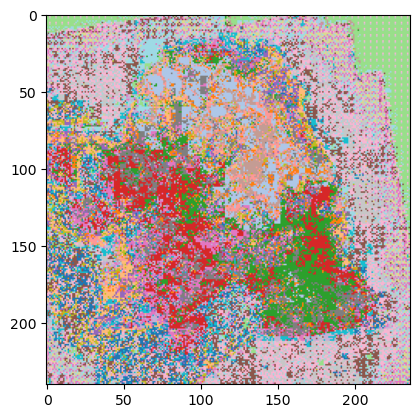

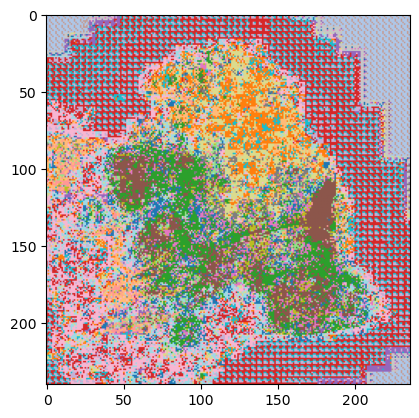

In [52]:
extended = sns.color_palette('tab20') + sns.color_palette('tab20b') + sns.color_palette('tab20c')
for sid, d in sample_to_embs.items():
    x = d['clustered_patches']
    rgb = display_labeled_as_rgb(x, cmap=extended)
    plt.imshow(rgb)
    plt.show()

In [53]:
from pathlib import Path
out_dir = '/data/estorrs/DINO-extended/data/runs/HT397B1_v1/codex/run_1/results'
Path(out_dir).mkdir(parents=True, exist_ok=True)

In [54]:
for fp, d in sample_to_embs.items():
    sid = fp.split('/')[-1].split('.')[0]
    torch.save(d, os.path.join(out_dir, f'{sid}_{n_clusters}knn.pt'))